In [1]:
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import wget
import tarfile
import xml.etree.ElementTree as ET
import cv2
import matplotlib.patches as patches
from PIL import Image
# import argparse

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download and extract 2007 VOC dataset

In [3]:
url_train = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
url_test = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'

train_name = wget.download(url_train)
test_name = wget.download(url_test)

100% [......................................................................] 460032000 / 460032000

In [4]:
os.listdir(".")

['.ipynb_checkpoints',
 'ML',
 'mlflow',
 'VOCtest_06-Nov-2007.tar',
 'VOCtrainval_06-Nov-2007.tar',
 'YOLO_get_data.ipynb']

In [6]:
train_tar = tarfile.open(train_name, mode='r')
test_tar = tarfile.open(test_name, mode='r')

In [7]:
train_tar.extractall('.')
train_tar.close()

In [8]:
test_tar.extractall('.')
test_tar.close()

### Convert XML annotations to text files

In [2]:
sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'trainval'), ('2007', 'test')]
classes_dict = {'person':0, 'bird':1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6, 'aeroplane':7, 
                'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 'bottle':14, 
                'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tvmonitor':19}
inverse_classes_dict = {value: key for key, value in classes_dict.items()}

classes_names = list(classes_dict.keys())

In [3]:
def convert_to_txt(year, image_id, file):
    input_file = os.path.join('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(input_file)
    root = tree.getroot()
    
    # find all objects in the image
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        class_name = obj.find('name').text
        # we skip the hard images (difficult == 1)
        if class_name not in classes_names or int(difficult) == 1:
            continue
        class_id = classes_names.index(class_name)
        bounding_box = obj.find('bndbox')
        box_positions = (int(bounding_box.find('xmin').text), int(bounding_box.find('ymin').text),
             int(bounding_box.find('xmax').text), int(bounding_box.find('ymax').text))
        # write bounding box positions and then class name
        file.write(' ' + ','.join([str(position) for position in box_positions]) + ',' + str(class_id))

In [4]:
for year, image_set in sets:
    print(year, image_set)
    with open(os.path.join('VOCdevkit/VOC{}/ImageSets/Main/{}.txt'.format(year, image_set)), 'r') as f:
        image_ids = [filename.strip() for filename in f.readlines()]
    with open(os.path.join("VOCdevkit", '{}_{}.txt'.format(year, image_set)), 'w') as f:
        for image_id in image_ids:
            f.write('VOCdevkit/VOC{}/JPEGImages/{}.jpg'.format(year, image_id))
            convert_to_txt(year, image_id, f)
            f.write('\n')

2007 train
2007 val
2007 trainval
2007 test


### Prepare input images and output tensors
 - all images before using YOLO are **resized to 448x448** and include 3 RGB channels
 - in YOLO object detection is modelled as a **regression problem**. The image is divided into **SxS grid and for each grid cell predicts B bounding boxes, confidence for those boxes and C class probabilities**. (for Pascal VOC 2007 S=7, B=2 and we have 20 classes so C=20) Consequently, the output (final prediction) is **7x7x30 tensor**.


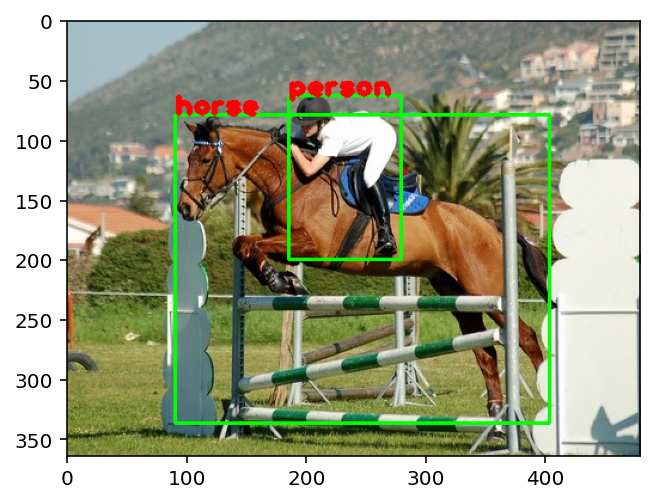

In [3]:
FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
thickness = 1
font_size = 1.5
dimension = (448, 448)

def show_image_with_classes(file='2007_train.txt'):
    # select random photo from train
    with open(os.path.join('VOCdevkit', file)) as f:
        lines = f.readlines()
        length = len(lines)
        sample = lines[1].strip().split()
        path = sample[0]
        objects = sample[1:]

        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

        for image_object in objects:
            positions, class_number = image_object.split(",")[:4], image_object.split(",")[-1]

            cv2.rectangle(image, (int(positions[0]), int(positions[1])), (int(positions[2]), int(positions[3])), green, 2)
            cv2.putText(image, inverse_classes_dict[int(class_number)], (int(positions[0]), int(positions[1])), FONT, font_size, red, thickness+2)
            # resize to the neural network input (not necessary to show image)
            cv2.resize(image, dimension, interpolation = cv2.INTER_AREA)

        # Display the image
        plt.imshow(image)

show_image_with_classes()

### Pytorch VOC 2007 dataset

In [5]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [6]:
# transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# test set transform to tensor and normalize
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

In [7]:
from torchvision.datasets import VOCDetection

train_set = VOCDetection(
    root="./data", 
    year='2007', 
    image_set='train', 
    transform=train_transformations, 
    download=True
)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar


In [8]:
validation_set = VOCDetection(
    root="./data", 
    year='2007', 
    image_set='val', 
    transform=test_transformations, 
    download=True
)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar


In [9]:
test_set = VOCDetection(
    root="./data", 
    year='2007', 
    image_set='test', 
    transform=test_transformations, 
    download=True
)

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar


In [12]:
train_set[0]

(tensor([[[-0.3961, -0.3804, -0.3647,  ..., -0.4275, -0.4275, -0.4118],
          [-0.4118, -0.3882, -0.3882,  ..., -0.3882, -0.3647, -0.3961],
          [-0.4118, -0.3961, -0.3961,  ..., -0.3882, -0.3804, -0.3961],
          ...,
          [-0.4824, -0.4745, -0.4588,  ..., -0.4510, -0.4902, -0.4980],
          [-0.4510, -0.4745, -0.4824,  ..., -0.4510, -0.4667, -0.4745],
          [-0.4118, -0.4196, -0.4431,  ..., -0.5216, -0.5059, -0.4745]],
 
         [[-0.3961, -0.3804, -0.3647,  ..., -0.4275, -0.4275, -0.4118],
          [-0.4118, -0.3882, -0.3882,  ..., -0.3961, -0.3725, -0.4039],
          [-0.4118, -0.3961, -0.3961,  ..., -0.3961, -0.3882, -0.4039],
          ...,
          [-0.4745, -0.4667, -0.4510,  ..., -0.4510, -0.4902, -0.4980],
          [-0.4431, -0.4667, -0.4745,  ..., -0.4510, -0.4667, -0.4745],
          [-0.4118, -0.4196, -0.4431,  ..., -0.5059, -0.4902, -0.4588]],
 
         [[-0.3961, -0.3804, -0.3647,  ..., -0.4275, -0.4275, -0.4118],
          [-0.4118, -0.3882,

In [13]:
# collate_function to create batches

def collate_function(self, batch):
    """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """
    images = []
    boxes = []
    labels = []
    difficulties = []
    
    for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

    images = torch.stack(images, dim=0)
    return images, boxes, labels, difficulties

In [17]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_function)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [45]:
len(train_set)

2501

In [46]:
train_set[2][0]

tensor([[[ 0.0745,  0.1294,  0.1137,  ...,  0.8902,  0.9686,  0.8980],
         [ 0.1059,  0.1451,  0.1294,  ...,  0.8275,  0.9137,  0.8588],
         [ 0.0667,  0.1137,  0.1216,  ...,  0.8039,  0.8824,  0.8510],
         ...,
         [ 0.2000,  0.1686,  0.2000,  ...,  0.4118,  0.5059,  0.6078],
         [ 0.1686,  0.1686,  0.1843,  ...,  0.4510,  0.4353,  0.5451],
         [ 0.1608,  0.2235,  0.1765,  ...,  0.5059,  0.2392,  0.2314]],

        [[-0.3804, -0.3412, -0.3490,  ...,  0.8667,  0.9529,  0.8824],
         [-0.3490, -0.3255, -0.3333,  ...,  0.8196,  0.9059,  0.8353],
         [-0.3882, -0.3569, -0.3412,  ...,  0.7961,  0.8745,  0.8275],
         ...,
         [-0.1686, -0.2235, -0.1922,  ...,  0.4745,  0.5608,  0.6392],
         [-0.1843, -0.2000, -0.2078,  ...,  0.5137,  0.4902,  0.5843],
         [-0.1922, -0.1451, -0.2078,  ...,  0.5608,  0.3020,  0.3098]],

        [[-0.6706, -0.6314, -0.6627,  ...,  0.9216,  0.9922,  0.9216],
         [-0.6392, -0.6157, -0.6471,  ...,  0

In [15]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()

In [18]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [19]:
import torchvision

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

RuntimeError: DataLoader worker (pid(s) 29176, 18800, 12248, 21108) exited unexpectedly

It may be needed to create instance of VOC dataset as done here: 
https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/datasets.py